<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-gurobi-with-guesses-about-AR" data-toc-modified-id="Use-gurobi-with-guesses-about-AR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Use gurobi with guesses about AR</a></span><ul class="toc-item"><li><span><a href="#Helper-classes-and-functions" data-toc-modified-id="Helper-classes-and-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Helper classes and functions</a></span></li></ul></li><li><span><a href="#Plot" data-toc-modified-id="Plot-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qtensor

import time

## Use gurobi with guesses about AR




* $UB$ - upper bound on maxcut cost
* $LB$ - lower bound 
* $C$ - optimal cost
$UB>C$


$AR = \frac{LB}{C} > \frac{LB}{UB}$

### Helper classes and functions

In [2]:
def log_linear_fit(x, y, x_ext):
    a = np.polyfit(x, np.log(y), deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return np.exp(ln)

def linear_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def cubic_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=3)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def octa_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=6)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

In [3]:
from dataclasses import dataclass

@dataclass
class Line:
    x: np.array 
    y: np.array
        
    def average_flat(self):
        if len(self.y.shape)>1:
            self.std = np.nanstd(self.y, -1)
            self.y = np.nanmean(self.y, -1)
            
@dataclass
class LineFit(Line):
    def log_linear_fit(self, x_ext):
        self.fit_x = x_ext
        self.average_flat()
        self.fit = log_linear_fit(self.x, self.y, self.fit_x)
        return self.fit
    
    def cubic_fit(self, x_ext):
        self.fit_x = x_ext
        self.average_flat()
        self.fit = cubic_fit(self.x, self.y, self.fit_x)
        return self.fit

In [4]:
def approx_ratio(p):
    try:
        AR = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val']
        if AR>0:
            return AR
        else:
            raise KeyError
    except KeyError:
        AR = 1 - (0.3-np.log2(p)*0.05)
    return AR

## Plot

In [5]:
import xarray as xar

In [6]:
quant = xar.open_dataarray('../data/quantum_nsamples1000_d3.nc')
quant


<xarray.DataArray (types: 2, p: 5, N: 84)>
array([[[4.773500e+00, 5.016500e+00, ..., 2.469950e+01, 2.494250e+01],
        [4.922000e+00, 5.408000e+00, ..., 4.477400e+01, 4.526000e+01],
        ...,
        [5.615000e+00, 7.235000e+00, ..., 1.384550e+02, 1.400750e+02],
        [6.209000e+00, 8.801000e+00, ..., 2.187530e+02, 2.213450e+02]],

       [[4.041050e+02, 9.941630e+02, ..., 4.878886e+04, 4.937892e+04],
        [4.180850e+02, 1.058201e+03, ..., 5.290760e+04, 5.354771e+04],
        ...,
        [4.833250e+02, 1.357045e+03, ..., 7.212837e+04, 7.300209e+04],
        [5.392450e+02, 1.613197e+03, ..., 8.860331e+04, 8.967726e+04]]])
Coordinates:
  * N        (N) int32 10 46 82 118 154 190 ... 2818 2854 2890 2926 2962 2998
  * p        (p) int32 3 6 12 20 32
  * types    (types) object 'transport' 'destructive'

In [7]:
gw = xar.open_dataarray('../data/quantum_nsamples1000_d3.nc')
gw

<xarray.DataArray (types: 2, p: 5, N: 84)>
array([[[4.773500e+00, 5.016500e+00, ..., 2.469950e+01, 2.494250e+01],
        [4.922000e+00, 5.408000e+00, ..., 4.477400e+01, 4.526000e+01],
        ...,
        [5.615000e+00, 7.235000e+00, ..., 1.384550e+02, 1.400750e+02],
        [6.209000e+00, 8.801000e+00, ..., 2.187530e+02, 2.213450e+02]],

       [[4.041050e+02, 9.941630e+02, ..., 4.878886e+04, 4.937892e+04],
        [4.180850e+02, 1.058201e+03, ..., 5.290760e+04, 5.354771e+04],
        ...,
        [4.833250e+02, 1.357045e+03, ..., 7.212837e+04, 7.300209e+04],
        [5.392450e+02, 1.613197e+03, ..., 8.860331e+04, 8.967726e+04]]])
Coordinates:
  * N        (N) int32 10 46 82 118 154 190 ... 2818 2854 2890 2926 2962 2998
  * p        (p) int32 3 6 12 20 32
  * types    (types) object 'transport' 'destructive'

In [8]:
def plot_std_band(x, y, **kwargs):
    mean = np.mean(y, -1)
    std = np.std(y, -1)
    plt.fill_between(x, mean+std, mean-std, **kwargs)

In [9]:
def plot_advantage(p=6, datadir='../data'):
    fig = plt.figure(figsize=(8, 4))

    AR = approx_ratio(p)

    plt.yscale('log')
    plt.xscale('log')
    ## -- plot quantum
    quant = xar.open_dataarray(datadir+'/quantum_nsamples1000_d3.nc')
    x = quant.N
    qaoa_transport = quant.sel(types='transport', p=p)
    qaoa_dst_seq = quant.sel(types='destructive', p=p)

    plt.plot(x, qaoa_transport, color='red',
             label=f'QAOA w/ transport time (quality={np.round(AR, 3)})')
    plt.plot(x, qaoa_dst_seq, color='orange',
             label=f'QAOA w/ destructive sequential time (quality={np.round(AR, 3)})')
    
    gw = xar.open_dataarray(datadir+'/gw_times.nc')
    gwx = gw.N
    plt.plot(gwx, gw.mean('seed'), marker='*', color='green', label='Goemans-Williamson (quality=0.878)')
    plot_std_band(gwx, gw, alpha=0.1, color='green')
    
    opt = xar.open_dataarray(datadir+'/gurobi_opt_threads1.nc')
    plt.plot(opt.N, opt.mean('seeds'), marker='*', color='blue', label='Gurobi: optimal (quality=1.0)')
    plot_std_band(opt.N, opt, alpha=0.1, color='blue')
    

    match = xar.open_dataarray(datadir+'/gurobi_match_threads1.nc')
    plt.plot(match.N, match.sel(p=p).mean('seeds'), marker='*', color='magenta',
             label=f'Gurobi: optimal (quality={np.round(AR, 3)})')
    plot_std_band(match.N, match.sel(p=p), alpha=0.1, color='magenta')
    
    
    #plt.plot(opt.fit_x, opt.fit, '--', color='black', label='log-linear fit')
    #plt.plot(gw.fit_x, gw.fit, '--', color='black')
    plt.legend(loc='upper left')
    plt.ylabel('Time to solution')
    plt.title(f'p={p}')
    plt.grid()

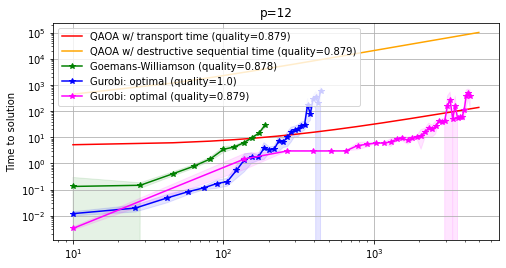

In [26]:
p = 12
plot_advantage(p=p)
plt.savefig(f"./pdf/p{p}_time_vs_n.pdf")

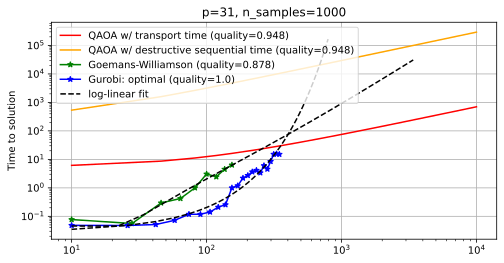

In [24]:
plot_advantage(p=31)